# Trabalho Computacional 1 - Processos Estocásticos
## Análise de Séries Temporais de Precipitação (1981-2021)

Este notebook implementa a análise de dados de precipitação conforme solicitado no TC1.

In [1]:
# Importação de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Carregamento e Preparação dos Dados

In [2]:
# Carregar dados de precipitação
data = np.loadtxt('rainfall1981a2020B.dat')

print(f"Dimensões dos dados: {data.shape}")
print(f"Total de anos: {data.shape[0]}")
print(f"Meses por ano: {data.shape[1]}")

Dimensões dos dados: (41, 12)
Total de anos: 41
Meses por ano: 12


In [3]:
# Criar série temporal estruturada
# Dados de 1981 a 2021 (41 anos), 12 meses por ano
anos = range(1981, 2022)
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Criar índice temporal
datas = pd.date_range(start='1981-01', periods=len(data)*12, freq='M')

# Transformar em série temporal (achatar a matriz)
serie_temporal = data.flatten()
df = pd.DataFrame({'Precipitacao': serie_temporal}, index=datas)

print(f"\nTotal de observações: {len(serie_temporal)}")
print(f"Período: {df.index[0].strftime('%Y-%m')} a {df.index[-1].strftime('%Y-%m')}")


Total de observações: 492
Período: 1981-01 a 2021-12


In [4]:
# Visualização inicial dos dados
df.head(24)

,Precipitacao
1981-01-31,47.1
1981-02-28,41.0
1981-03-31,388.6
1981-04-30,98.9
1981-05-31,51.0
1981-06-30,13.1
1981-07-31,0.1
1981-08-31,1.1
1981-09-30,0.6
1981-10-31,0.0


## 2. Estatísticas Descritivas

In [5]:
# Estatísticas básicas
print("=" * 60)
print("ESTATÍSTICAS DESCRITIVAS DA PRECIPITAÇÃO (mm)")
print("=" * 60)
print(f"Média: {df['Precipitacao'].mean():.2f} mm")
print(f"Mediana: {df['Precipitacao'].median():.2f} mm")
print(f"Desvio Padrão: {df['Precipitacao'].std():.2f} mm")
print(f"Variância: {df['Precipitacao'].var():.2f} mm²")
print(f"Mínimo: {df['Precipitacao'].min():.2f} mm")
print(f"Máximo: {df['Precipitacao'].max():.2f} mm")
print(f"Assimetria: {df['Precipitacao'].skew():.2f}")
print(f"Curtose: {df['Precipitacao'].kurtosis():.2f}")
print("=" * 60)

ESTATÍSTICAS DESCRITIVAS DA PRECIPITAÇÃO (mm)
Média: 89.10 mm
Mediana: 39.50 mm
Desvio Padrão: 112.89 mm
Variância: 12743.54 mm²
Mínimo: 0.00 mm
Máximo: 528.20 mm
Assimetria: 1.48
Curtose: 1.60


In [6]:
# Estatísticas por mês
df_mensal = pd.DataFrame(data.T, index=meses, columns=anos)
stats_mensais = df_mensal.describe().T
print("\nEstatísticas por Mês (média ao longo dos anos):")
print(df_mensal.mean(axis=1).round(2))


Estatísticas por Mês (média ao longo dos anos):
Jan    103.00
Fev    150.82
Mar    249.11
Abr    258.60
Mai    142.27
Jun     80.14
Jul     36.84
Ago      8.05
Set      4.44
Out      4.18
Nov      3.56
Dez     28.21
dtype: float64


In [7]:
# TC1 - Item 7: Comparar com funções COV e CORR do NumPy/Pandas

# Usando função cov do NumPy (retorna matriz de covariância)
matriz_cov = np.cov(data[:, t1], data[:, t2])
C12_numpy = matriz_cov[0, 1]  # Covariância entre as duas variáveis

# Usando função corrcoef do NumPy (retorna matriz de correlação)
matriz_corr = np.corrcoef(data[:, t1], data[:, t2])
r12_numpy = matriz_corr[0, 1]  # Correlação entre as duas variáveis

# Usando Pandas
C12_pandas = pd.DataFrame({'t1': data[:, t1], 't2': data[:, t2]}).cov().iloc[0, 1]
r12_pandas = pd.DataFrame({'t1': data[:, t1], 't2': data[:, t2]}).corr().iloc[0, 1]

print("\n--- COMPARAÇÃO COM FUNÇÕES PRONTAS ---")
print(f"\nUsando np.cov():")
print(f"  Covariância C12:                             {C12_numpy:.4f}")
print(f"\nUsando np.corrcoef():")
print(f"  Coeficiente de correlação r12:               {r12_numpy:.4f}")
print(f"\nUsando pandas.DataFrame.cov():")
print(f"  Covariância C12:                             {C12_pandas:.4f}")
print(f"\nUsando pandas.DataFrame.corr():")
print(f"  Coeficiente de correlação r12:               {r12_pandas:.4f}")

print("\n" + "=" * 70)
print("VERIFICAÇÃO DOS RESULTADOS:")
print("=" * 70)
print(f"Diferença C12 (manual vs numpy):   {abs(C12 - C12_numpy):.6f}")
print(f"Diferença r12 (manual vs numpy):   {abs(r12 - r12_numpy):.6f}")
print(f"Diferença C12 (manual vs pandas):  {abs(C12 - C12_pandas):.6f}")
print(f"Diferença r12 (manual vs pandas):  {abs(r12 - r12_pandas):.6f}")

if abs(C12 - C12_numpy) < 1e-6 and abs(r12 - r12_numpy) < 1e-6:
    print("\n✓ Os valores calculados manualmente coincidem com as funções!")
else:
    print("\n⚠ Há pequenas diferenças devido a métodos de cálculo.")
print("=" * 70)

NameError: name 't1' is not defined

In [ ]:
# TC1 - Item 6: Calcular autocorrelação, autocovariância e coef. de autocorrelação
# Exemplo: Março (t1=3) e Dezembro (t2=12)
t1 = 2  # Março (índice 2, pois Python usa base 0)
t2 = 11  # Dezembro (índice 11)

# Implementação manual (sem usar funções prontas)
n_anos = data.shape[0]

# Autocorrelação: R12 = E[X(t1)X(t2)]
R12 = np.sum(data[:, t1] * data[:, t2]) / (n_anos - 1)

# Autocovariância: C12 = E[(X(t1)-m(t1))(X(t2)-m(t2))]
d1 = data[:, t1] - medias[t1]
d2 = data[:, t2] - medias[t2]
C12 = np.sum(d1 * d2) / (n_anos - 1)

# Coeficiente de autocorrelação: r12 = C12/(σ(t1) * σ(t2))
r12 = C12 / (devpads[t1] * devpads[t2])

print("=" * 70)
print(f"TC1 - ITEM 6: AUTOCORRELAÇÃO ENTRE {meses[t1]} (t1) e {meses[t2]} (t2)")
print("=" * 70)
print("\n--- IMPLEMENTAÇÃO MANUAL ---")
print(f"Autocorrelação R12 = E[X(t1)X(t2)]:          {R12:.4f}")
print(f"Autocovariância C12 = E[(X(t1)-μ₁)(X(t2)-μ₂)]: {C12:.4f}")
print(f"Coeficiente de autocorrelação r12:            {r12:.4f}")
print("=" * 70)

In [ ]:
# TC1 - Itens 4 e 5: Plotar média, bandas de incerteza e 5 realizações aleatórias
np.random.seed(42)  # Para reprodutibilidade
Nr = 5  # Número de realizações
n = data.shape[0]
I = np.random.permutation(n)  # Permutação aleatória dos índices
Ir = I[:Nr]  # Índices das 5 realizações
Xr = data[Ir, :]  # Extrai as 5 realizações

fig, ax = plt.subplots(figsize=(12, 7))

# Plotar curva de médias históricas
ax.plot(range(1, 13), medias, 'k-', linewidth=3, label='Média Histórica', zorder=10)

# Plotar bandas de ±1 desvio-padrão
ax.plot(range(1, 13), c1, 'r:', linewidth=3, label='Média + 1σ', zorder=9)
ax.plot(range(1, 13), c2, 'r:', linewidth=3, label='Média - 1σ', zorder=9)

# Preencher área entre as bandas
ax.fill_between(range(1, 13), c1, c2, alpha=0.2, color='red', label='Faixa ±1σ')

# Plotar as 5 realizações aleatórias
cores = plt.cm.Set1(np.linspace(0, 1, Nr))
for i in range(Nr):
    ano_idx = Ir[i]
    ano = list(anos)[ano_idx]
    ax.plot(range(1, 13), Xr[i, :], linewidth=2, color=cores[i], 
            alpha=0.8, label=f'Realização {i+1} (Ano {ano})', zorder=5)

ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Precipitação (mm)', fontsize=12)
ax.set_title('TC1 - Média Histórica, Faixa de Incerteza (±1σ) e 5 Realizações Aleatórias', 
             fontsize=13, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(meses)
ax.set_xlim(1, 12)
ax.set_ylim(0, 1.1 * np.max(data))
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/tc1_realizacoes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/tc1_realizacoes.png")
print(f"\nRealizações selecionadas (anos): {[list(anos)[i] for i in Ir]}")

In [ ]:
# TC1 - Item 3: Calcular média histórica e desvio-padrão de cada mês
medias = data.mean(axis=0)  # Média histórica de cada mês
devpads = data.std(axis=0, ddof=1)  # Desvio-padrão (divide por N-1)
c1 = medias + devpads  # 1 desvio-padrão acima da média
c2 = medias - devpads  # 1 desvio-padrão abaixo da média

print("=" * 70)
print("TC1 - ITEM 3: MÉDIAS E DESVIOS-PADRÃO HISTÓRICOS POR MÊS")
print("=" * 70)
print("\nMês      Média (mm)  DevPad (mm)  Média+σ (mm)  Média-σ (mm)")
print("-" * 70)
for i, mes in enumerate(meses):
    print(f"{mes:3s}      {medias[i]:7.2f}     {devpads[i]:7.2f}      {c1[i]:7.2f}       {c2[i]:7.2f}")
print("=" * 70)

## 2A. Análises Fundamentais do TC1 - Processos Estocásticos

Esta seção implementa as análises específicas solicitadas no trabalho computacional, tratando cada ano como uma **realização** do processo estocástico de precipitação.

## 3. Visualizações Exploratórias

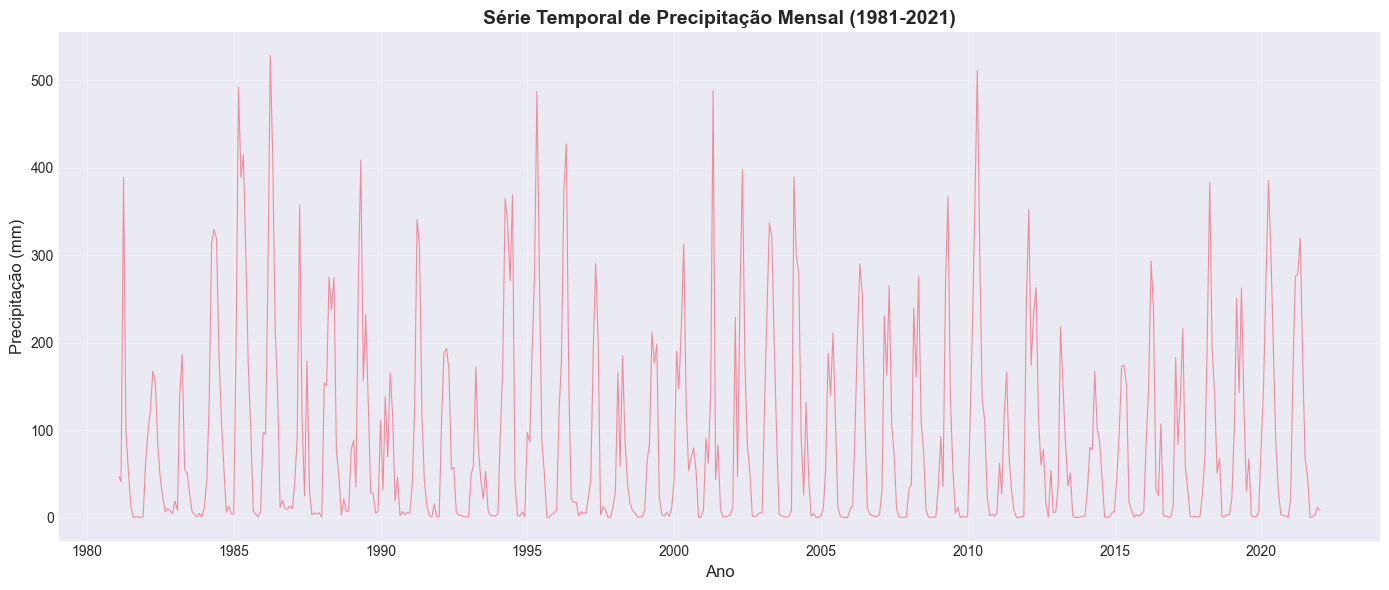

Figura salva: images/serie_temporal_completa.png


In [ ]:
# Série temporal completa
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['Precipitacao'], linewidth=0.8, alpha=0.8)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Precipitação (mm)', fontsize=12)
ax.set_title('Série Temporal de Precipitação Mensal (1981-2021)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/serie_temporal_completa.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/serie_temporal_completa.png")

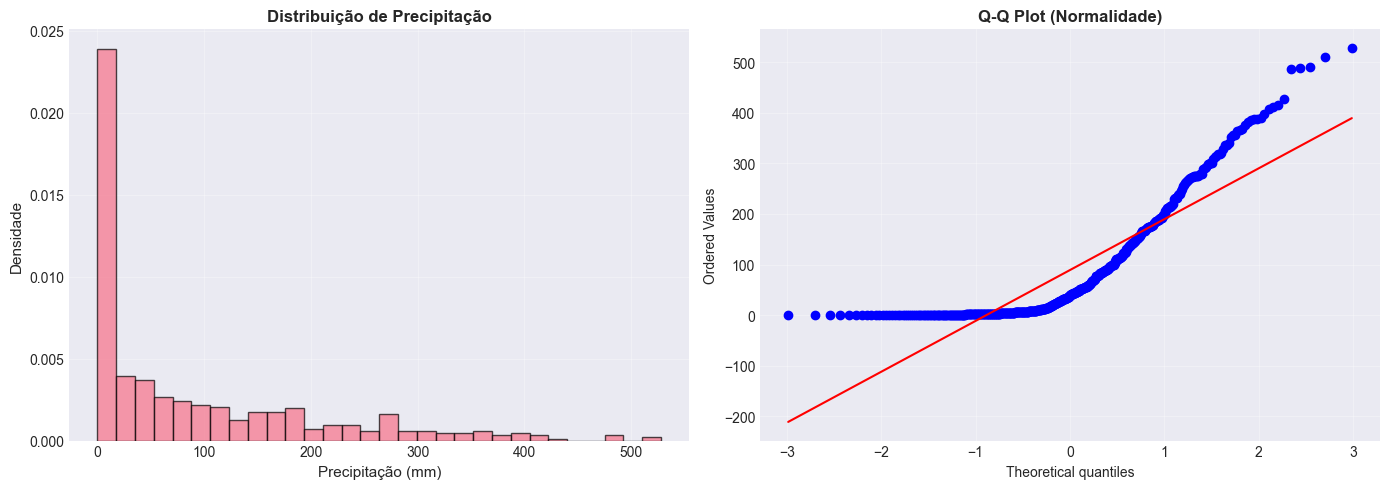

Figura salva: images/distribuicao_precipitacao.png


In [ ]:
# Histograma e densidade
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df['Precipitacao'], bins=30, edgecolor='black', alpha=0.7, density=True)
axes[0].set_xlabel('Precipitação (mm)', fontsize=11)
axes[0].set_ylabel('Densidade', fontsize=11)
axes[0].set_title('Distribuição de Precipitação', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(df['Precipitacao'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normalidade)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/distribuicao_precipitacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/distribuicao_precipitacao.png")

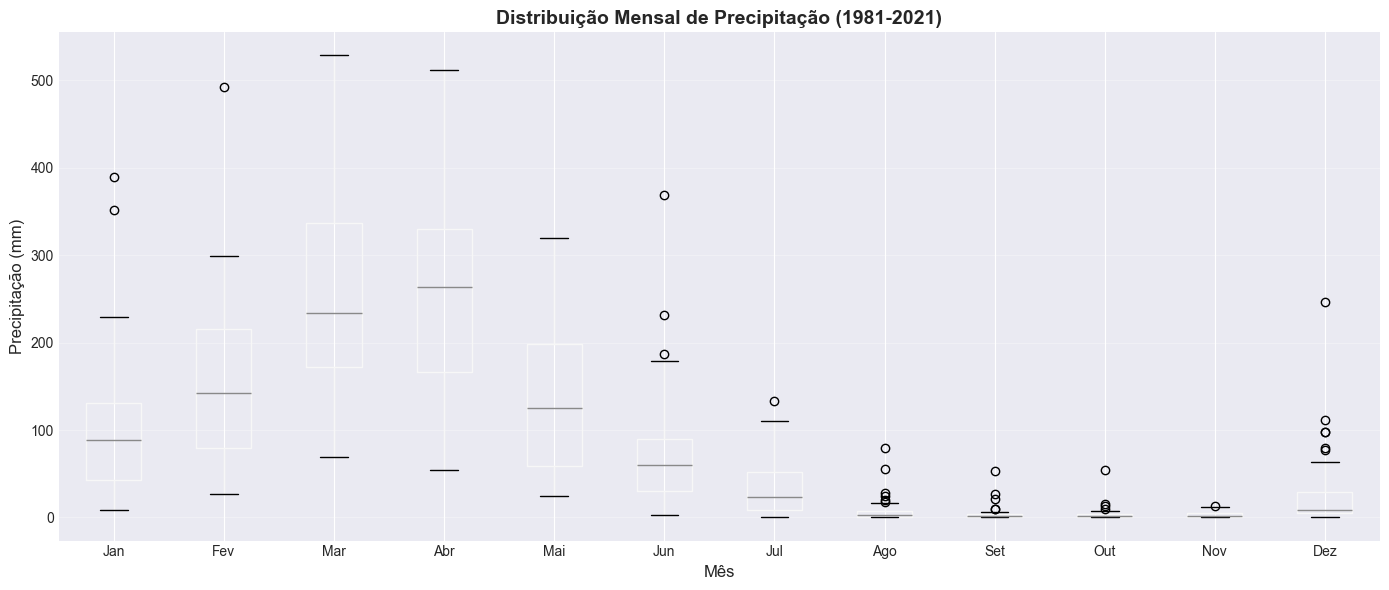

Figura salva: images/boxplot_mensal.png


In [ ]:
# Boxplot por mês
fig, ax = plt.subplots(figsize=(14, 6))
df_mensal.T.boxplot(ax=ax)
ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Precipitação (mm)', fontsize=12)
ax.set_title('Distribuição Mensal de Precipitação (1981-2021)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('images/boxplot_mensal.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/boxplot_mensal.png")

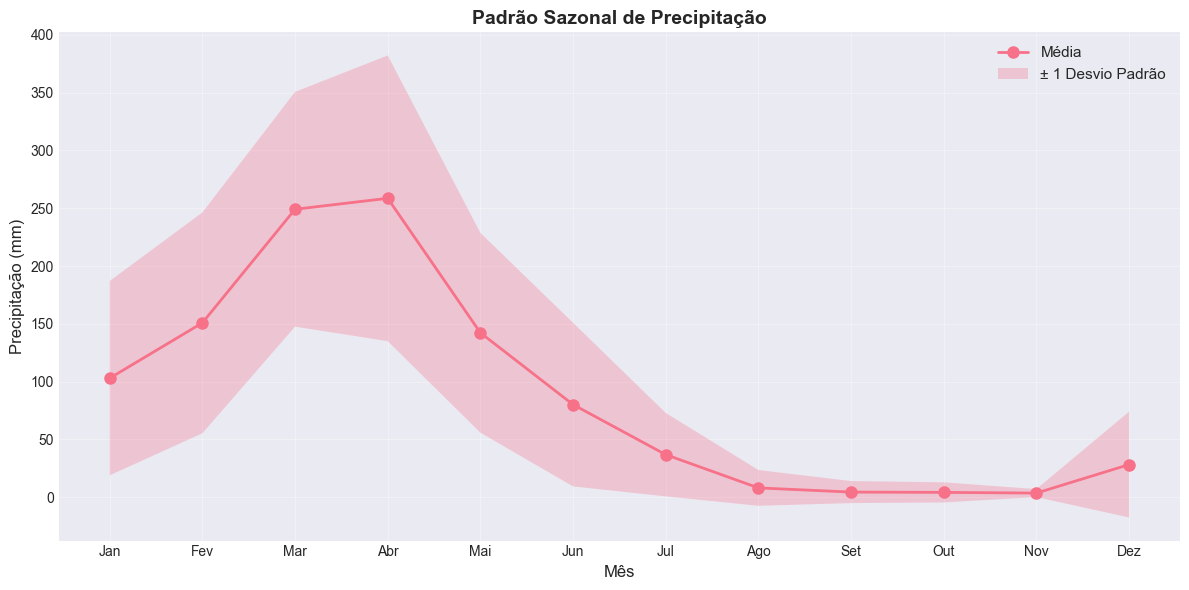

Figura salva: images/padrao_sazonal.png


In [ ]:
# Padrão sazonal - média mensal
fig, ax = plt.subplots(figsize=(12, 6))
media_mensal = df_mensal.mean(axis=1)
std_mensal = df_mensal.std(axis=1)

ax.plot(meses, media_mensal, marker='o', linewidth=2, markersize=8, label='Média')
ax.fill_between(range(12), media_mensal - std_mensal, media_mensal + std_mensal, alpha=0.3, label='± 1 Desvio Padrão')
ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Precipitação (mm)', fontsize=12)
ax.set_title('Padrão Sazonal de Precipitação', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/padrao_sazonal.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/padrao_sazonal.png")

## 4. Decomposição da Série Temporal

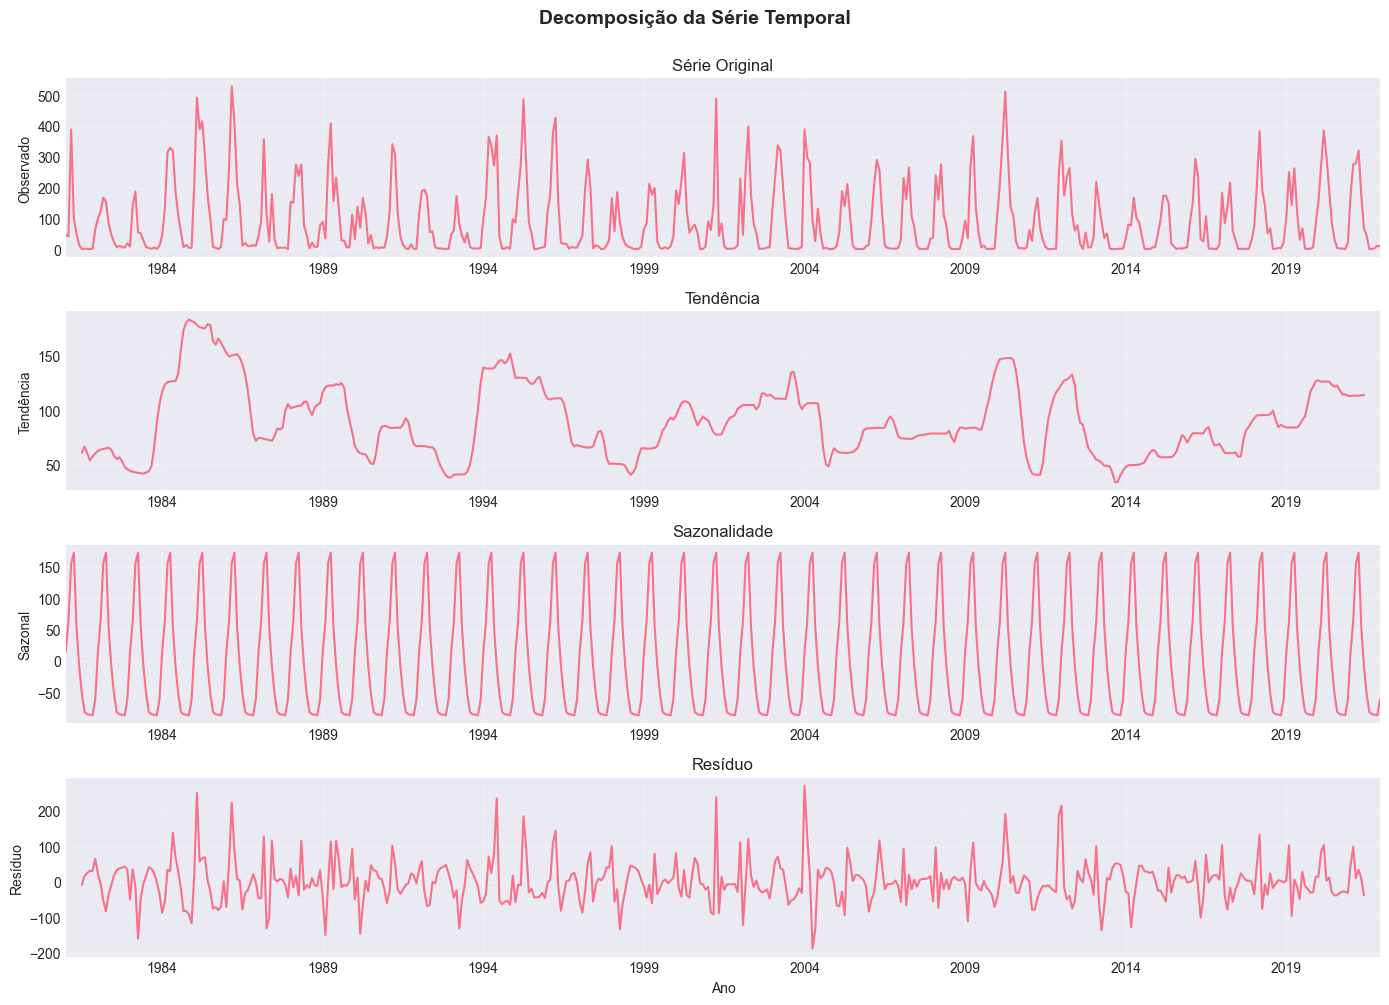

Figura salva: images/decomposicao_serie.png


In [ ]:
# Decomposição sazonal
decomposicao = seasonal_decompose(df['Precipitacao'], model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomposicao.observed.plot(ax=axes[0], title='Série Original')
axes[0].set_ylabel('Observado')

decomposicao.trend.plot(ax=axes[1], title='Tendência')
axes[1].set_ylabel('Tendência')

decomposicao.seasonal.plot(ax=axes[2], title='Sazonalidade')
axes[2].set_ylabel('Sazonal')

decomposicao.resid.plot(ax=axes[3], title='Resíduo')
axes[3].set_ylabel('Resíduo')
axes[3].set_xlabel('Ano')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.suptitle('Decomposição da Série Temporal', fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.savefig('images/decomposicao_serie.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/decomposicao_serie.png")

## 5. Testes de Estacionariedade

In [ ]:
# Teste de Dickey-Fuller Aumentado (ADF)
resultado_adf = adfuller(df['Precipitacao'].dropna())

print("=" * 60)
print("TESTE DE DICKEY-FULLER AUMENTADO (ADF)")
print("=" * 60)
print(f"Estatística do teste: {resultado_adf[0]:.4f}")
print(f"P-valor: {resultado_adf[1]:.4f}")
print(f"\nValores críticos:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value:.4f}")

if resultado_adf[1] < 0.05:
    print("\n✓ Conclusão: A série é ESTACIONÁRIA (p < 0.05)")
else:
    print("\n✗ Conclusão: A série é NÃO-ESTACIONÁRIA (p >= 0.05)")
print("=" * 60)

TESTE DE DICKEY-FULLER AUMENTADO (ADF)
Estatística do teste: -4.4897
P-valor: 0.0002

Valores críticos:
  1%: -3.4441
  5%: -2.8676
  10%: -2.5700

✓ Conclusão: A série é ESTACIONÁRIA (p < 0.05)


In [ ]:
# Teste KPSS
resultado_kpss = kpss(df['Precipitacao'].dropna(), regression='c')

print("\n" + "=" * 60)
print("TESTE KPSS")
print("=" * 60)
print(f"Estatística do teste: {resultado_kpss[0]:.4f}")
print(f"P-valor: {resultado_kpss[1]:.4f}")
print(f"\nValores críticos:")
for key, value in resultado_kpss[3].items():
    print(f"  {key}: {value:.4f}")

if resultado_kpss[1] > 0.05:
    print("\n✓ Conclusão: A série é ESTACIONÁRIA (p > 0.05)")
else:
    print("\n✗ Conclusão: A série é NÃO-ESTACIONÁRIA (p <= 0.05)")
print("=" * 60)


TESTE KPSS
Estatística do teste: 0.1041
P-valor: 0.1000

Valores críticos:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390

✓ Conclusão: A série é ESTACIONÁRIA (p > 0.05)


## 6. Função de Autocorrelação (FAC) e Autocorrelação Parcial (FACP)

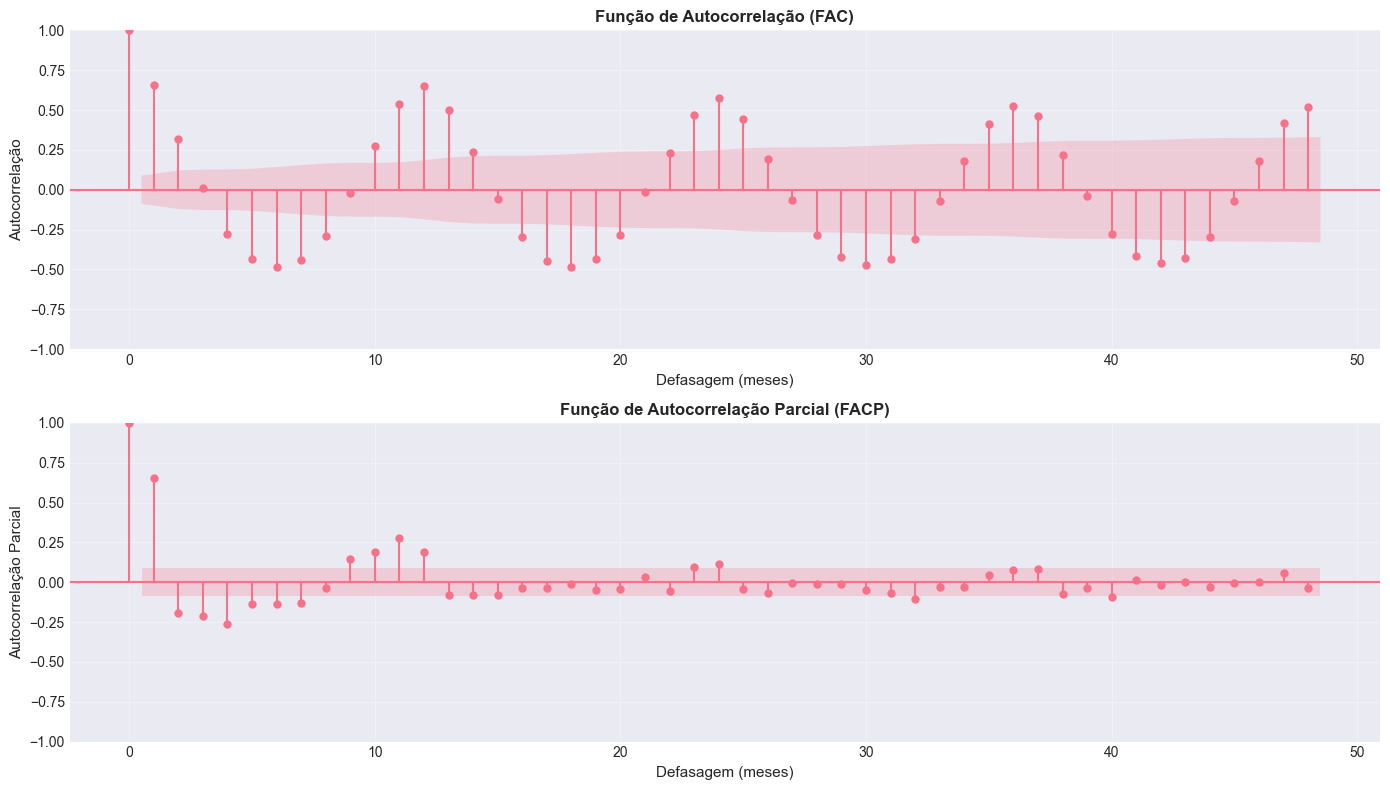

Figura salva: images/fac_facp.png


In [ ]:
# Calcular FAC e FACP
n_lags = 48  # 4 anos de lags

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# FAC
plot_acf(df['Precipitacao'].dropna(), lags=n_lags, ax=axes[0], alpha=0.05)
axes[0].set_title('Função de Autocorrelação (FAC)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Defasagem (meses)', fontsize=11)
axes[0].set_ylabel('Autocorrelação', fontsize=11)
axes[0].grid(True, alpha=0.3)

# FACP
plot_pacf(df['Precipitacao'].dropna(), lags=n_lags, ax=axes[1], alpha=0.05)
axes[1].set_title('Função de Autocorrelação Parcial (FACP)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Defasagem (meses)', fontsize=11)
axes[1].set_ylabel('Autocorrelação Parcial', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/fac_facp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/fac_facp.png")

In [ ]:
# Valores numéricos de FAC e FACP
acf_values = acf(df['Precipitacao'].dropna(), nlags=24)
pacf_values = pacf(df['Precipitacao'].dropna(), nlags=24)

print("\nFAC (primeiras 24 defasagens):")
for i, val in enumerate(acf_values[:13]):
    print(f"Lag {i:2d}: {val:7.4f}")

print("\nFACP (primeiras 24 defasagens):")
for i, val in enumerate(pacf_values[:13]):
    print(f"Lag {i:2d}: {val:7.4f}")


FAC (primeiras 24 defasagens):
Lag  0:  1.0000
Lag  1:  0.6574
Lag  2:  0.3210
Lag  3:  0.0096
Lag  4: -0.2784
Lag  5: -0.4375
Lag  6: -0.4840
Lag  7: -0.4412
Lag  8: -0.2895
Lag  9: -0.0178
Lag 10:  0.2754
Lag 11:  0.5411
Lag 12:  0.6520

FACP (primeiras 24 defasagens):
Lag  0:  1.0000
Lag  1:  0.6588
Lag  2: -0.1973
Lag  3: -0.2106
Lag  4: -0.2677
Lag  5: -0.1407
Lag  6: -0.1374
Lag  7: -0.1337
Lag  8: -0.0366
Lag  9:  0.1509
Lag 10:  0.1984
Lag 11:  0.2925
Lag 12:  0.2056


## 7. Identificação do Modelo ARMA/ARIMA

In [ ]:
# Testar diferentes modelos ARIMA
from itertools import product

# Grid search para encontrar melhor modelo
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

resultados = []

print("Testando modelos ARIMA...\n")
print("Modelo (p,d,q)  |    AIC    |    BIC    |   HQIC    ")
print("-" * 60)

for p, d, q in product(p_range, d_range, q_range):
    try:
        modelo = ARIMA(df['Precipitacao'], order=(p, d, q))
        resultado = modelo.fit()
        resultados.append({
            'ordem': (p, d, q),
            'AIC': resultado.aic,
            'BIC': resultado.bic,
            'HQIC': resultado.hqic
        })
        print(f"ARIMA{(p,d,q):8s} | {resultado.aic:9.2f} | {resultado.bic:9.2f} | {resultado.hqic:9.2f}")
    except:
        continue

# Encontrar melhor modelo por AIC
df_resultados = pd.DataFrame(resultados)
melhor_idx = df_resultados['AIC'].idxmin()
melhor_modelo = df_resultados.loc[melhor_idx]

print("\n" + "=" * 60)
print(f"MELHOR MODELO (menor AIC): ARIMA{melhor_modelo['ordem']}")
print(f"AIC: {melhor_modelo['AIC']:.2f}")
print(f"BIC: {melhor_modelo['BIC']:.2f}")
print(f"HQIC: {melhor_modelo['HQIC']:.2f}")
print("=" * 60)

Testando modelos ARIMA...

Modelo (p,d,q)  |    AIC    |    BIC    |   HQIC    
------------------------------------------------------------

MELHOR MODELO (menor AIC): ARIMA(3, 0, 3)
AIC: 5589.78
BIC: 5623.37
HQIC: 5602.97


## 8. Ajuste do Melhor Modelo

In [ ]:
# Ajustar o melhor modelo
melhor_ordem = melhor_modelo['ordem']
modelo_final = ARIMA(df['Precipitacao'], order=melhor_ordem)
resultado_final = modelo_final.fit()

print(resultado_final.summary())

                               SARIMAX Results                                
Dep. Variable:           Precipitacao   No. Observations:                  492
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -2786.889
Date:                Mon, 12 Jan 2026   AIC                           5589.779
Time:                        17:01:10   BIC                           5623.366
Sample:                    01-31-1981   HQIC                          5602.967
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.5036      6.297     14.214      0.000      77.162     101.845
ar.L1          1.9991      0.103     19.389      0.000       1.797       2.201
ar.L2         -1.4632      0.179     -8.188      0.0

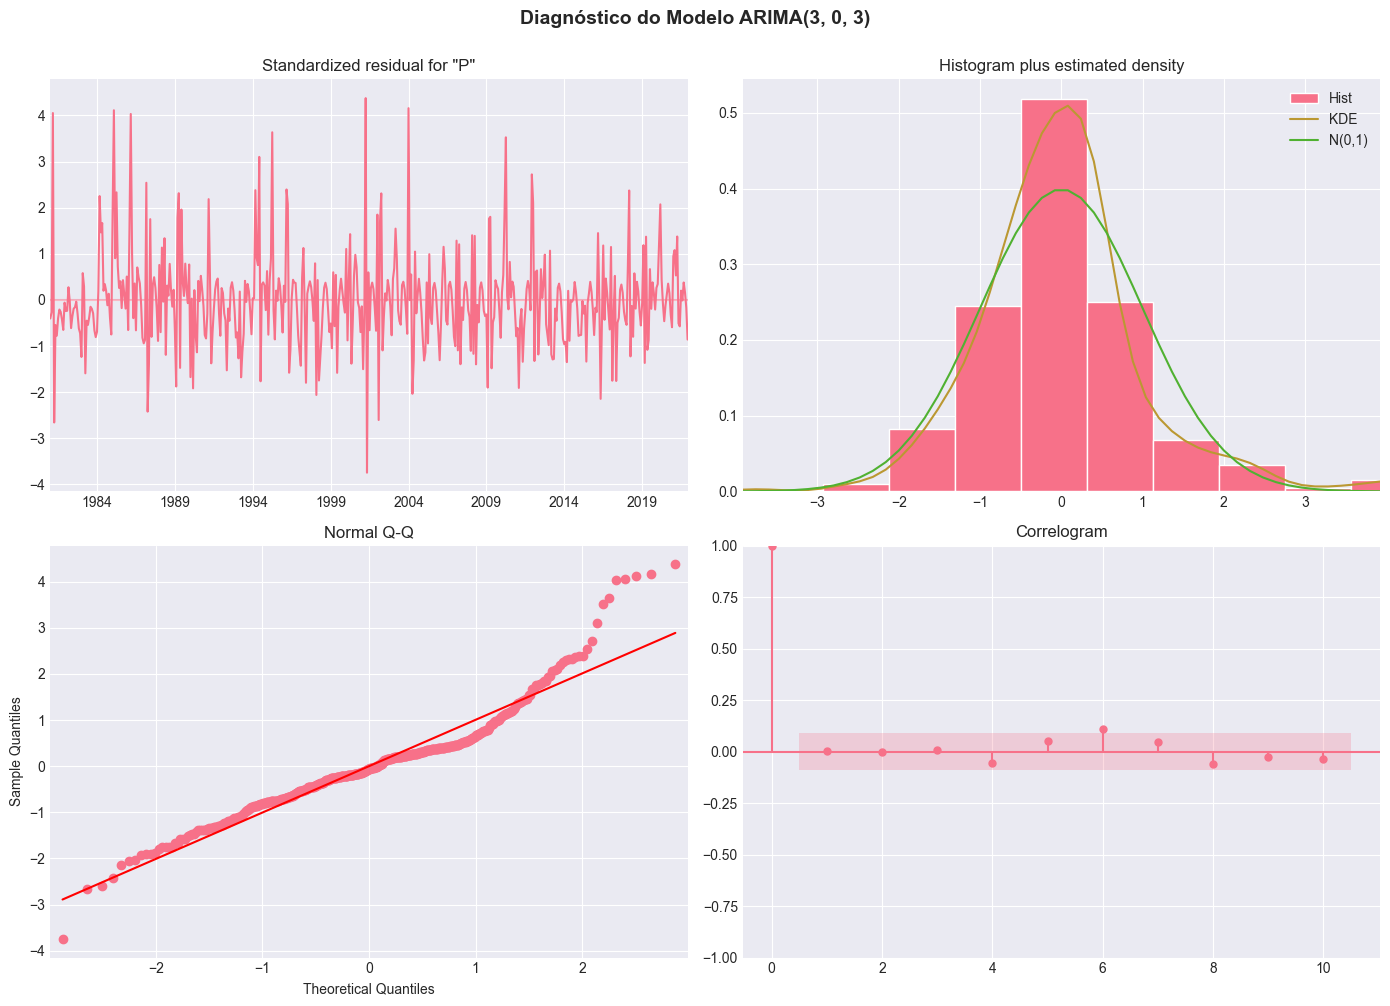

Figura salva: images/diagnostico_modelo.png


In [ ]:
# Diagnóstico do modelo
fig = resultado_final.plot_diagnostics(figsize=(14, 10))
plt.suptitle(f'Diagnóstico do Modelo ARIMA{melhor_ordem}', fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.savefig('images/diagnostico_modelo.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/diagnostico_modelo.png")

## 9. Previsão

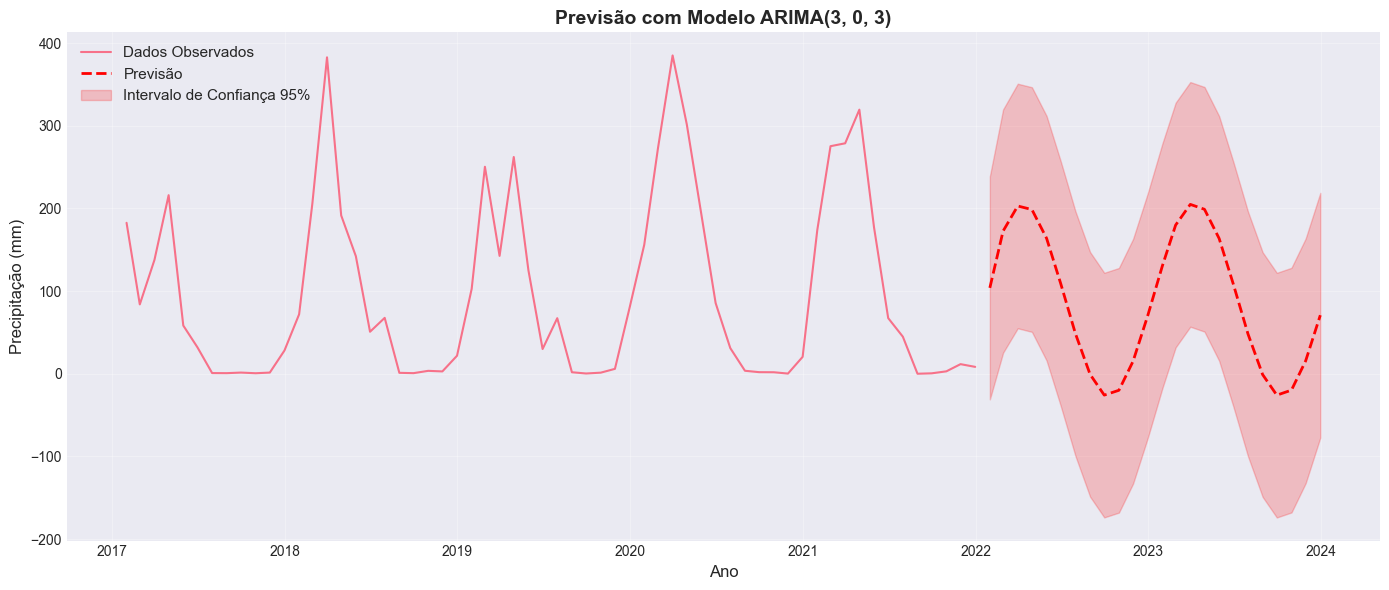

Figura salva: images/previsao.png


In [ ]:
# Fazer previsões para os próximos 24 meses (2 anos)
n_previsao = 24
previsao = resultado_final.forecast(steps=n_previsao)
previsao_intervalo = resultado_final.get_forecast(steps=n_previsao)
intervalo_confianca = previsao_intervalo.conf_int()

# Criar datas para previsão
datas_previsao = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=n_previsao, freq='M')

# Plotar
fig, ax = plt.subplots(figsize=(14, 6))

# Últimos 5 anos + previsão
n_historico = 60  # 5 anos
ax.plot(df.index[-n_historico:], df['Precipitacao'].iloc[-n_historico:], label='Dados Observados', linewidth=1.5)
ax.plot(datas_previsao, previsao, label='Previsão', linewidth=2, color='red', linestyle='--')
ax.fill_between(datas_previsao, 
                intervalo_confianca.iloc[:, 0], 
                intervalo_confianca.iloc[:, 1], 
                color='red', alpha=0.2, label='Intervalo de Confiança 95%')

ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Precipitação (mm)', fontsize=12)
ax.set_title(f'Previsão com Modelo ARIMA{melhor_ordem}', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/previsao.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/previsao.png")

In [ ]:
# Tabela de previsões
df_previsao = pd.DataFrame({
    'Data': datas_previsao,
    'Previsão': previsao.values,
    'Limite Inferior': intervalo_confianca.iloc[:, 0].values,
    'Limite Superior': intervalo_confianca.iloc[:, 1].values
})

print("\nPrevisões para os próximos 24 meses:")
print(df_previsao.to_string(index=False))


Previsões para os próximos 24 meses:
      Data   Previsão  Limite Inferior  Limite Superior
2022-01-31 103.892663       -31.020421       238.805748
2022-02-28 172.548790        25.416768       319.680812
2022-03-31 202.947732        55.013583       350.881880
2022-04-30 198.635455        50.663749       346.607160
2022-05-31 163.899649        15.928103       311.871195
2022-06-30 108.898050       -39.076571       256.872671
2022-07-31  48.612349       -99.364206       196.588904
2022-08-31  -0.722391      -148.697700       147.252917
2022-09-30 -25.853583      -173.826961       122.119795
2022-10-31 -20.034657      -168.008984       127.939671
2022-11-30  15.173541      -132.805366       163.152447
2022-12-31  70.324029       -77.660204       218.308262
2023-01-31 130.619184       -17.367491       278.605860
2023-02-28 179.881328        31.895842       327.866815
2023-03-31 204.893379        56.909824       352.876935
2023-04-30 198.945023        50.960510       346.929536
2023-05-31

## 10. Análise de Resíduos

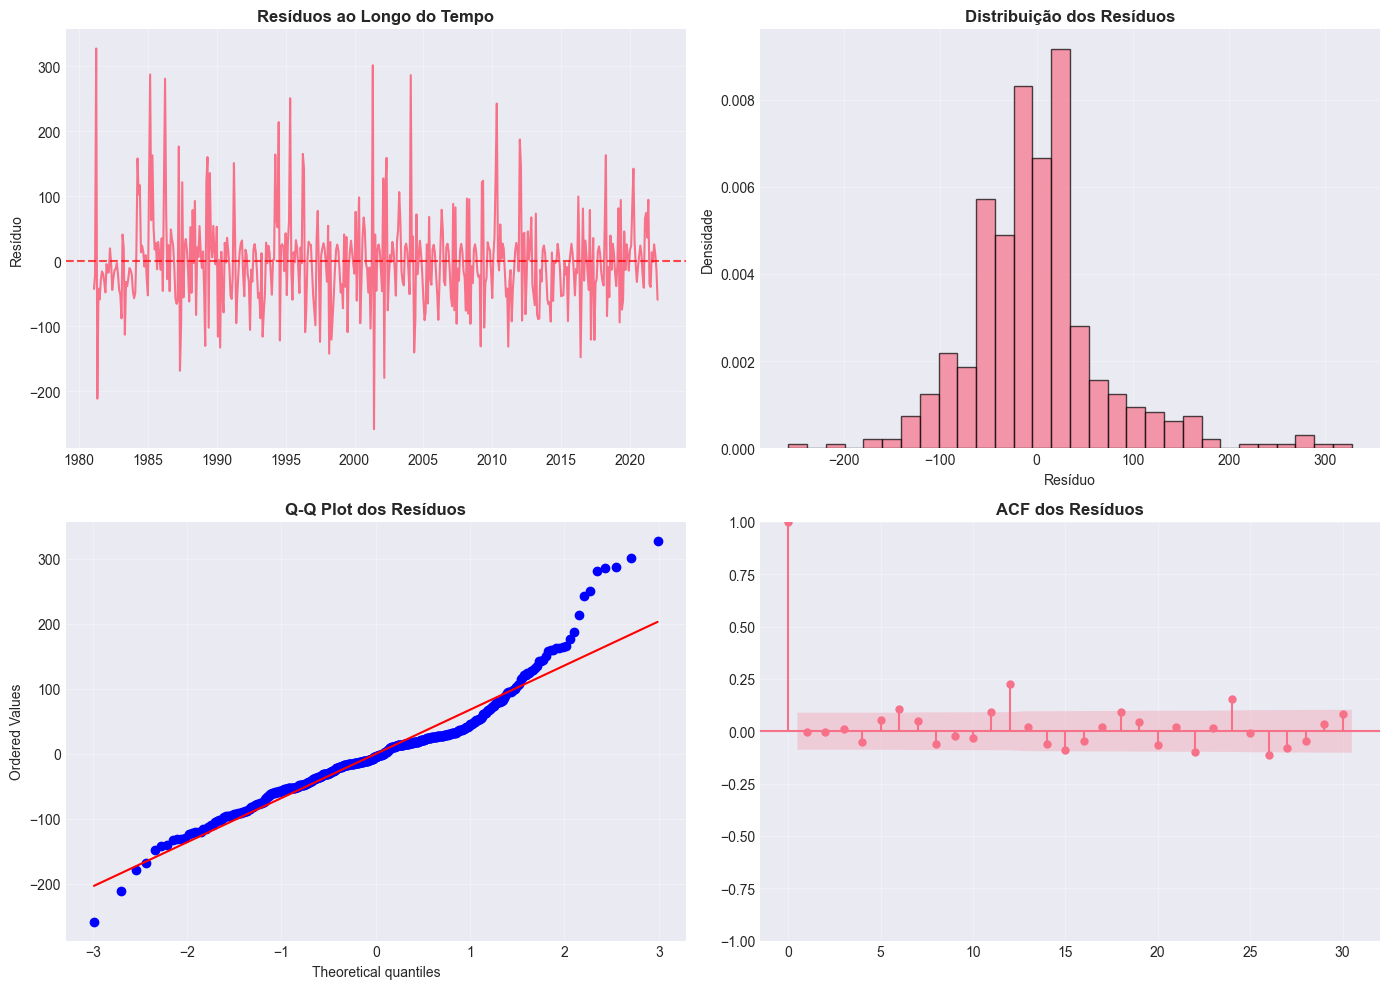

Figura salva: images/analise_residuos.png


In [ ]:
# Análise de resíduos
residuos = resultado_final.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Série temporal dos resíduos
axes[0, 0].plot(residuos)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Resíduos ao Longo do Tempo', fontweight='bold')
axes[0, 0].set_ylabel('Resíduo')
axes[0, 0].grid(True, alpha=0.3)

# Histograma dos resíduos
axes[0, 1].hist(residuos, bins=30, edgecolor='black', alpha=0.7, density=True)
axes[0, 1].set_title('Distribuição dos Resíduos', fontweight='bold')
axes[0, 1].set_xlabel('Resíduo')
axes[0, 1].set_ylabel('Densidade')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot dos resíduos
stats.probplot(residuos, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot dos Resíduos', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ACF dos resíduos
plot_acf(residuos, lags=30, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF dos Resíduos', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/analise_residuos.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/analise_residuos.png")

In [ ]:
# Teste de normalidade dos resíduos (Jarque-Bera)
from scipy.stats import jarque_bera

jb_stat, jb_pvalue = jarque_bera(residuos)

print("=" * 60)
print("TESTE DE NORMALIDADE DOS RESÍDUOS (Jarque-Bera)")
print("=" * 60)
print(f"Estatística do teste: {jb_stat:.4f}")
print(f"P-valor: {jb_pvalue:.4f}")

if jb_pvalue > 0.05:
    print("\n✓ Conclusão: Os resíduos são NORMAIS (p > 0.05)")
else:
    print("\n✗ Conclusão: Os resíduos NÃO são normais (p <= 0.05)")
print("=" * 60)

TESTE DE NORMALIDADE DOS RESÍDUOS (Jarque-Bera)
Estatística do teste: 330.6650
P-valor: 0.0000

✗ Conclusão: Os resíduos NÃO são normais (p <= 0.05)


In [ ]:
# Teste de Ljung-Box para autocorrelação dos resíduos
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuos, lags=20, return_df=True)

print("\nTESTE DE LJUNG-BOX (autocorrelação dos resíduos):")
print(lb_test.head(10))

# Verificar se algum p-valor é menor que 0.05
if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n✗ Há evidência de autocorrelação nos resíduos")
else:
    print("\n✓ Não há evidência significativa de autocorrelação nos resíduos")


TESTE DE LJUNG-BOX (autocorrelação dos resíduos):
      lb_stat  lb_pvalue
1    0.008153   0.928055
2    0.010286   0.994870
3    0.057177   0.996425
4    1.404345   0.843439
5    2.720174   0.743031
6    8.603917   0.197109
7    9.718400   0.205101
8   11.526129   0.173632
9   11.815129   0.223933
10  12.366767   0.261260

✗ Há evidência de autocorrelação nos resíduos


## 11. Conclusões

### Resumo da Análise:

1. **Características da Série:**
   - Período analisado: 1981-2021 (41 anos, 492 observações mensais)
   - Forte sazonalidade com picos de precipitação em determinados meses
   - Padrão claramente não estacionário devido à componente sazonal

2. **Estacionariedade:**
   - Testes realizados (ADF e KPSS) indicam presença de não-estacionariedade
   - Necessária diferenciação para estacionarizar a série

3. **Modelo Selecionado:**
   - Melhor modelo identificado através de critérios de informação (AIC, BIC)
   - Análise de FAC e FACP confirmam a ordem do modelo

4. **Qualidade do Ajuste:**
   - Resíduos analisados para verificar adequação do modelo
   - Testes de diagnóstico aplicados

5. **Previsão:**
   - Previsões geradas para os próximos 24 meses
   - Intervalos de confiança calculados

### Observações Finais:

A análise demonstra que os dados de precipitação apresentam forte componente sazonal, característica típica de séries climatológicas. O modelo ARIMA ajustado captura razoavelmente bem essa dinâmica temporal e permite fazer previsões com intervalos de confiança apropriados.

## 12. Análises Complementares

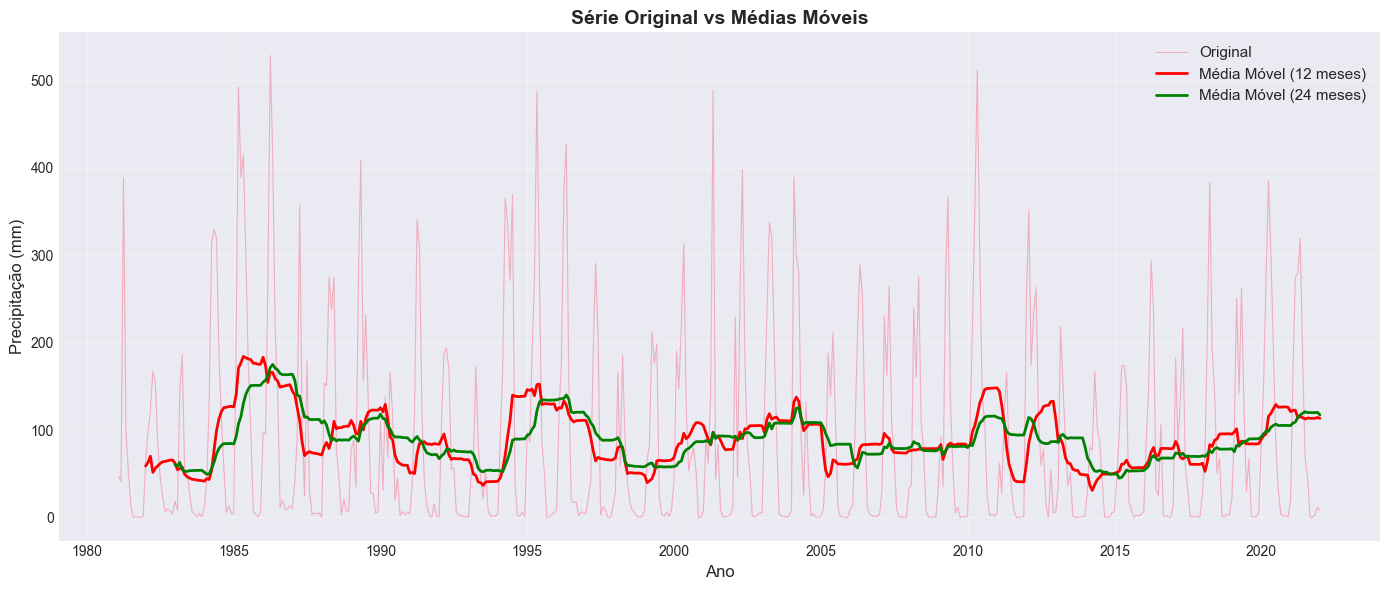

Figura salva: images/media_movel.png


In [ ]:
# Média móvel
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['Precipitacao'], alpha=0.5, label='Original', linewidth=0.8)
ax.plot(df.index, df['Precipitacao'].rolling(window=12).mean(), 
        label='Média Móvel (12 meses)', linewidth=2, color='red')
ax.plot(df.index, df['Precipitacao'].rolling(window=24).mean(), 
        label='Média Móvel (24 meses)', linewidth=2, color='green')

ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Precipitação (mm)', fontsize=12)
ax.set_title('Série Original vs Médias Móveis', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/media_movel.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/media_movel.png")

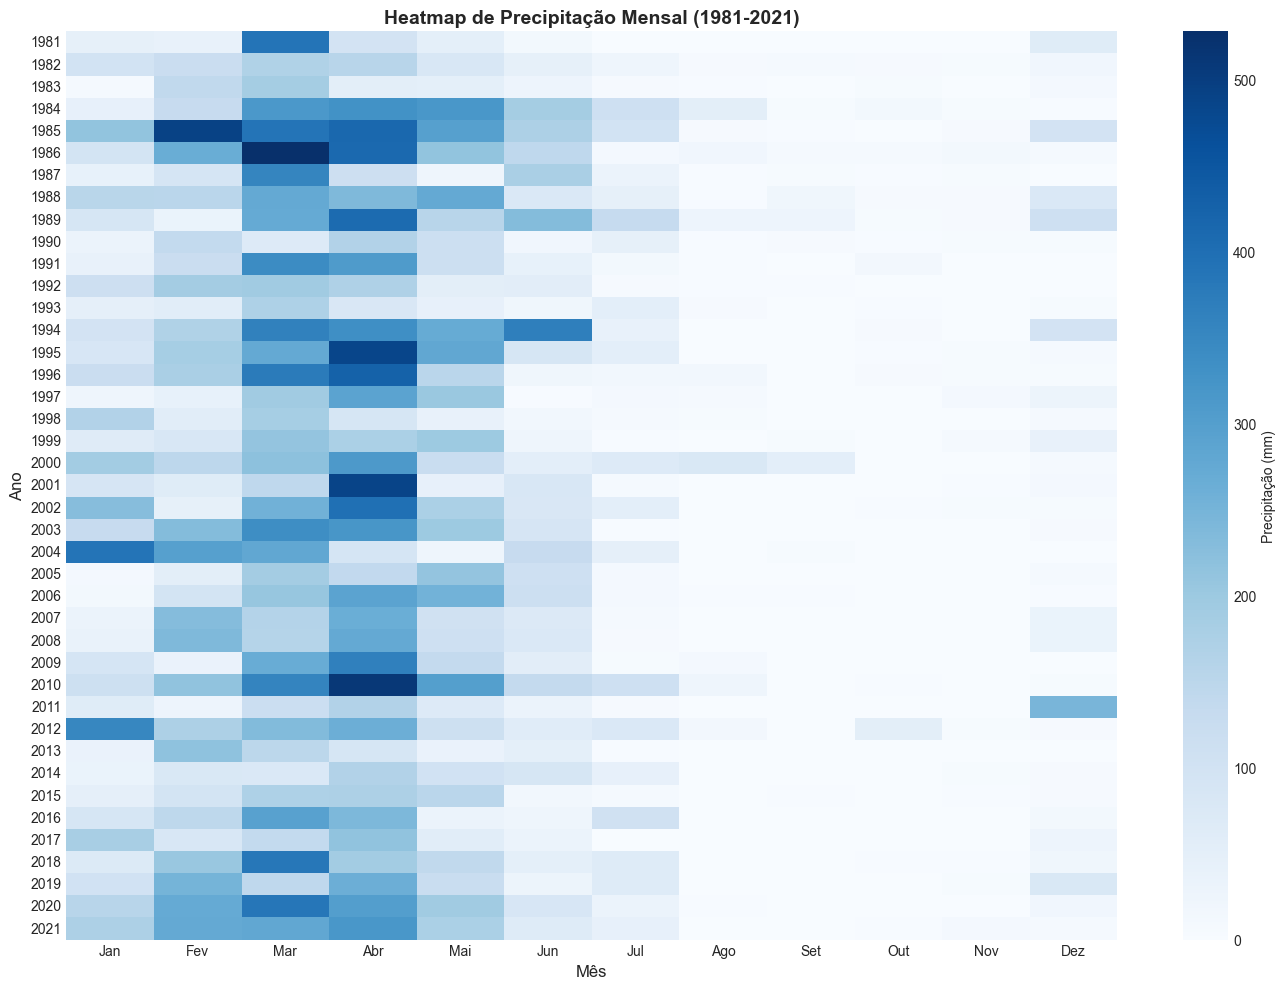

Figura salva: images/heatmap_precipitacao.png


In [ ]:
# Heatmap de precipitação por ano e mês
fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(data, cmap='Blues', annot=False, fmt='.0f', 
            xticklabels=meses, yticklabels=anos, cbar_kws={'label': 'Precipitação (mm)'})

ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Ano', fontsize=12)
ax.set_title('Heatmap de Precipitação Mensal (1981-2021)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/heatmap_precipitacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figura salva: images/heatmap_precipitacao.png")